In [10]:
working_directory = '/mnt/DataRAID/melismail/PDAC'
import os
os.chdir(working_directory)
from pickle_utils import write_pickle, read_pickle

import sys, math
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir 
from os.path import isfile, join
from numpy import argmax
from tifffile import imread, imsave
from glob import glob


import sklearn
from sklearn import linear_model
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics, preprocessing
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report
from scikitplot.metrics import plot_roc, plot_precision_recall, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

np.random.seed(109)

In [11]:
base_path = '/mnt/DataRAID/melismail/PDAC/data'
preprocessing_path ='Preprocessing_mask_annotation'
model_path = 'InceptionV3' #VGG-16 #ResNet50
classification_path = 'Classification'
plot_path = 'plots/Classification' 
class_path = 'six_classes/celltypes'

In [12]:
df_dataset = read_pickle(path=os.path.join(base_path, preprocessing_path, model_path, f"{model_path}_celltypes_lbl_df.pkl"))

In [4]:
print(df_dataset.head())

   Pseudonym  tile_id    lbl_mask  Acinar cells  Alpha cells  B cells  Basal  \
0  IAA2LDX17  (1, 23)  non-cancer           0.0          0.0      0.0    0.0   
1  IAA2LDX17  (1, 27)  non-cancer           0.0          0.0      1.0    2.0   
2  IAA2LDX17  (1, 28)  non-cancer           0.0          0.0      1.0    1.0   
3  IAA2LDX17  (1, 29)  non-cancer           1.0          0.0      0.0    1.0   
4  18QH2FGR4  (2, 17)  non-cancer           0.0          0.0      0.0    0.0   

   Beta cells  Classical_CEACAM  Classical_KRT7  ...  NK cells  Schwann cells  \
0         0.0               1.0             2.0  ...       0.0            0.0   
1         0.0               8.0             0.0  ...       0.0            0.0   
2         1.0              12.0             0.0  ...       2.0            1.0   
3         0.0               2.0             0.0  ...       0.0            0.0   
4         0.0               0.0             0.0  ...       0.0            0.0   

   T cells  iCAF  myCAF_ACTA2  m

In [4]:
X = df_dataset["Features"].to_list()
y = df_dataset["most_prevalent_cancer"]

In [6]:
y_dic = {idx: i for idx, i in enumerate(np.unique(y))}
classes = sorted(y_dic.items(), key=lambda item: item[0])
classes = [i[1] for i in classes]
print(y_dic)
print(classes)

{0: 'Basal', 1: 'Classical_CEACAM', 2: 'Classical_KRT7', 3: 'Classical_REG4', 4: 'Classical_TFF1', 5: 'non-cancer'}
['Basal', 'Classical_CEACAM', 'Classical_KRT7', 'Classical_REG4', 'Classical_TFF1', 'non-cancer']


In [7]:
#y = label_binarize(y, classes=classes)
#n_classes = y.shape[1]

In [8]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
n_classes = 6

In [9]:
print(y)

[2 1 1 ... 2 5 5]


non-cancer          1849
Classical_TFF1       152
Classical_CEACAM     135
Basal                 98
Classical_KRT7        91
Classical_REG4         4
Name: most_prevalent_cancer, dtype: int64


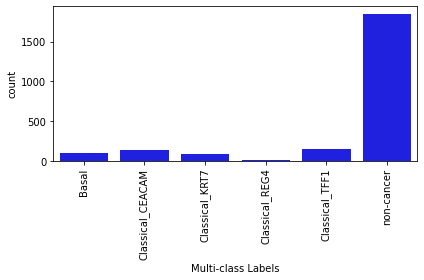

In [13]:
sns.countplot(data=df_dataset, x="most_prevalent_cancer", order=sorted(df_dataset["most_prevalent_cancer"].unique()), color="blue")
plt.xlabel('Multi-class Labels')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f'{model_path}_six_class_countplot.png', dpi=300)
print(df_dataset["most_prevalent_cancer"].value_counts())

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109)
#print(f"Training target statistics: {Counter(y_train)}")
#print(f"Testing target statistics: {Counter(y_test)}")

In [12]:
def build_and_test(X_tr, X_te, y_tr, y_te, plot_dir:str, model_name:str, parameter:dict, scaler:str, balancer:str, cv: int):
    print(model_name, scaler, balancer, parameter, cv)
        
    direct = os.path.join(plot_dir, model_name, scaler, balancer) 
    os.makedirs(direct, exist_ok=True)

    model_dir = os.path.join(base_path, classification_path, class_path, model_path, model_name, scaler, balancer)
    os.makedirs(direct, exist_ok=True)

    target_file = os.path.join(model_dir, f"Classifier_{cv}.pkl")
    if os.path.isfile(target_file):
                               return read_pickle(target_file)

    
    if balancer == 'RandomOversampler' and model_name == 'LogisticRegression':
        reg_dic = {f'Model_Name': model_name,
                   f'Balancer': balancer,
                   f'Scaler': scaler}
        return reg_dic

    #scale data
    if scaler == 'StandardScaler':
        std_scaler = StandardScaler().fit(X_tr + X_te)
        X_tr_scaled = std_scaler.transform(X_tr)
        X_te_scaled = std_scaler.transform(X_te)
    elif scaler == 'MinMaxScaler':
        minmax_scaler = MinMaxScaler().fit(X_tr + X_te)
        X_tr_scaled = minmax_scaler.transform(X_tr)
        X_te_scaled = minmax_scaler.transform(X_te)
    else:
        X_tr_scaled = X_tr
        X_te_scaled = X_te
    
    
    #balance dataset
    if balancer == 'RandomOversampler':
        over_sampler = RandomOverSampler(random_state=109)
        X_tr_sampled, y_tr_sampled = over_sampler.fit_resample(X_tr_scaled, y_tr)
    elif balancer == 'RandomUndersampler':
        under_sampler = RandomUnderSampler(random_state=109)
        X_tr_sampled, y_tr_sampled = under_sampler.fit_resample(X_tr_scaled, y_tr)
    else:
        X_tr_sampled, y_tr_sampled = X_tr_scaled, y_tr
    
     #build model
    if model_name == 'SVM':
        parameters = parameter
        grid = GridSearchCV(svm.SVC(), param_grid = parameters, n_jobs = -1, refit=True, verbose=2, cv=cv)
        grid.fit(X_tr_sampled, y_tr_sampled)
        print(grid.best_params_)
        model = svm.SVC(probability=True, **grid.best_params_)
        model.fit(X_tr_sampled, y_tr_sampled)
        y_pred = model.predict(X_te_scaled)
    elif model_name == 'LogisticRegression':
        parameters = parameter
        grid = GridSearchCV(LogisticRegression(max_iter=10000), param_grid = parameters, n_jobs = -1, refit=True, verbose=2, cv=cv)
        grid.fit(X_tr_sampled, y_tr_sampled)
        model = LogisticRegression(max_iter=10000, **grid.best_params_)
        model.fit(X_tr_sampled, y_tr_sampled)
        y_pred = model.predict(X_te_scaled)
    elif model_name == 'RandomForest':
        parameters = parameter
        grid = GridSearchCV(RandomForestClassifier(), param_grid = parameters, n_jobs = -1, refit=True, verbose=3, cv=cv)
        grid.fit(X_tr_sampled, y_tr_sampled)
        model = RandomForestClassifier(**grid.best_params_)
        model.fit(X_tr_sampled, y_tr_sampled)
        y_pred = model.predict(X_te_scaled)
    else:
        print(f'WARNING no {model} model found!')
    
    
    y_score = model.predict_proba(X_te_scaled)
    #fpr0, tpr0, thresholds = roc_curve(y_te, y_score[:, 1])
    #roc_auc0 = auc(fpr0, tpr0)
                   
    
    #print metrices    
    result_dic = {f'Model Name': model_name,
                  "Model": model,
                  f'Balancer': balancer,
                  f'Scaler': scaler,
                  "Cross-Validation Folds": cv,
                  f'Precision score': precision_score(y_te, y_pred, average='micro'),
                  f'Recall score':  recall_score(y_te, y_pred, average='micro'),
                  f'F1-score score': f1_score(y_te, y_pred, average='micro'),
                  f'Accuracy score': accuracy_score(y_te, y_pred),
                  #f'Area under the ROC curve (AUC)': roc_auc0,
                  f'Grid_param': grid.best_params_,
                  'cm': confusion_matrix(y_te, y_pred),
                  'classification_report': classification_report(y_te, y_pred),
                  "y_score": y_score, "y_test": y_te, "y_pred": y_pred}

    write_pickle(path=target_file, obj=result_dic)               
    return result_dic

In [13]:
balancer_list = ['RandomOversampler', 'RandomUndersampler', '']
scaler_list = ['MinMaxScaler', 'StandardScaler', '']
ml_model_list = ['SVM', 'LogisticRegression', 'RandomForest']
parameter_list = [{'C':[0.1, 1] , 'kernel':('linear', 'poly')},
                  {'penalty':('none', 'l2'), 'C':[0.1, 1], 'multi_class':('ovr', 'multinomial'), 'solver':('lbfgs', 'sag')},
                  {'n_estimators':[100, 250], 'min_samples_split':[2, 4], 'bootstrap':[True, False]}]
cv_list = [4]
classification_dic = read_pickle(path= os.path.join(base_path, classification_path, class_path, model_path, f"{model_path}_classification_dict.pkl"))
if classification_dic is not None:
    already_done_set = {(class_dict["model_name"], class_dict["scaler"],  class_dict["balancer"],  class_dict["Cross-Validation Folds"])for class_dict in classification_dic}
else:
    already_done_set = set()
    classification_dic = []

new_classification_dict_list =[build_and_test(X_tr=X_train, X_te=X_test, y_tr=y_train, y_te=y_test, 
                                      plot_dir=os.path.join(base_path, plot_path, class_path, model_path), 
                                      model_name = m, scaler=s, balancer=b, parameter=p, cv=c)
                       for s in scaler_list
                       for b in balancer_list
                       for m, p in zip(ml_model_list, parameter_list)
                       for c in cv_list
                           if (m,s,b,c) not in already_done_set]

if balancer_list == 'RandomOversampler' and model_name == 'LogisticRegression':
        reg_dic = {f'Model_Name': model_name,
                    'Model': model,
                   f'Balancer': balancer,
                   f'Scaler': scaler}
if len(new_classification_dict_list) > 0:
    classification_dic.extend(new_classification_dict_list)
    write_pickle(path= os.path.join(base_path, classification_path, class_path, model_path, f"{model_path}_classification_dict.pkl"), obj=classification_dic)

path did not exist: /mnt/DataRAID/melismail/PDAC/data/Classification/six_classes/celltypes/ResNet50/ResNet50_classification_dict.pkl
SVM MinMaxScaler RandomOversampler {'C': [0.1, 1], 'kernel': ('linear', 'poly')} 4
LogisticRegression MinMaxScaler RandomOversampler {'penalty': ('none', 'l2'), 'C': [0.1, 1], 'multi_class': ('ovr', 'multinomial'), 'solver': ('lbfgs', 'sag')} 4
RandomForest MinMaxScaler RandomOversampler {'n_estimators': [100, 250], 'min_samples_split': [2, 4], 'bootstrap': [True, False]} 4
SVM MinMaxScaler RandomUndersampler {'C': [0.1, 1], 'kernel': ('linear', 'poly')} 4
LogisticRegression MinMaxScaler RandomUndersampler {'penalty': ('none', 'l2'), 'C': [0.1, 1], 'multi_class': ('ovr', 'multinomial'), 'solver': ('lbfgs', 'sag')} 4
RandomForest MinMaxScaler RandomUndersampler {'n_estimators': [100, 250], 'min_samples_split': [2, 4], 'bootstrap': [True, False]} 4
SVM MinMaxScaler  {'C': [0.1, 1], 'kernel': ('linear', 'poly')} 4
LogisticRegression MinMaxScaler  {'penalty':

/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting pena

[CV] END ....C=0.1, multi_class=ovr, penalty=l2, solver=sag; total time=111.5min
[CV] END ....C=0.1, multi_class=ovr, penalty=l2, solver=sag; total time=120.8min
[CV] END ....C=0.1, multi_class=ovr, penalty=l2, solver=sag; total time=124.2min
[CV] END ....C=0.1, multi_class=ovr, penalty=l2, solver=sag; total time=126.4min
[CV] END C=0.1, multi_class=multinomial, penalty=none, solver=sag; total time=126.9min
[CV] END C=0.1, multi_class=multinomial, penalty=none, solver=sag; total time=142.9min
[CV] END .C=0.1, multi_class=ovr, penalty=none, solver=lbfgs; total time= 5.2min
[CV] END .....C=1, multi_class=ovr, penalty=l2, solver=lbfgs; total time=10.3min
[CV] END C=1, multi_class=multinomial, penalty=none, solver=sag; total time=128.3min
[CV] END C=0.1, multi_class=multinomial, penalty=none, solver=sag; total time=144.9min
[CV] END C=0.1, multi_class=multinomial, penalty=none, solver=lbfgs; total time= 2.6min
[CV] END C=0.1, multi_class=multinomial, penalty=l2, solver=sag; total time=50.8

/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no 

RandomForest StandardScaler RandomOversampler {'n_estimators': [100, 250], 'min_samples_split': [2, 4], 'bootstrap': [True, False]} 4
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

[CV 3/4] END bootstrap=True, min_samples_split=4, n_estimators=100;, score=0.998 total time= 1.0min
SVM StandardScaler RandomUndersampler {'C': [0.1, 1], 'kernel': ('linear', 'poly')} 4
[CV 1/4] END bootstrap=True, min_samples_split=4, n_estimators=100;, score=0.998 total time= 1.0min
Fitting 4 folds for each of 4 candidates, totalling 16 fits
{'C': 0.1, 'kernel': 'linear'}
LogisticRegression StandardScaler RandomUndersampler {'penalty': ('none', 'l2'), 'C': [0.1, 1], 'multi_class': ('ovr', 'multinomial'), 'solver': ('lbfgs', 'sag')} 4
Fitting 4 folds for each of 16 candidates, totalling 64 fits


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting pena

RandomForest StandardScaler RandomUndersampler {'n_estimators': [100, 250], 'min_samples_split': [2, 4], 'bootstrap': [True, False]} 4
Fitting 4 folds for each of 8 candidates, totalling 32 fits
SVM StandardScaler  {'C': [0.1, 1], 'kernel': ('linear', 'poly')} 4
Fitting 4 folds for each of 4 candidates, totalling 16 fits
{'C': 0.1, 'kernel': 'poly'}
[CV 4/4] END bootstrap=False, min_samples_split=2, n_estimators=100;, score=1.000 total time= 1.5min
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .....C=0.1, multi_class=ovr, penalty=l2, solver=sag; total time=   7.7s
[CV 3/4] END bootstrap=True, min_samples_split=2, n_estimators=250;, score=0.240 total time=   0.6s
[CV 4/4] END bootstrap=True, min_samples_split=2, n_estimators=100;, score=0.999 total time= 1.0min
[CV 4/4] END bootstrap=False, min_samples_split=4, n_estimators=250;, score=1.000 total time= 2.6min
[CV] END ...C=0.1, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   0.2s
[CV

/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

LogisticRegression StandardScaler  {'penalty': ('none', 'l2'), 'C': [0.1, 1], 'multi_class': ('ovr', 'multinomial'), 'solver': ('lbfgs', 'sag')} 4
Fitting 4 folds for each of 16 candidates, totalling 64 fits


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting pena

[CV] END .....C=0.1, multi_class=ovr, penalty=l2, solver=sag; total time=28.7min
[CV] END .....C=0.1, multi_class=ovr, penalty=l2, solver=sag; total time=32.4min
[CV] END .....C=0.1, multi_class=ovr, penalty=l2, solver=sag; total time=32.9min
[CV] END .....C=0.1, multi_class=ovr, penalty=l2, solver=sag; total time=33.7min
[CV] END C=0.1, multi_class=multinomial, penalty=none, solver=sag; total time=35.0min
[CV] END C=0.1, multi_class=multinomial, penalty=none, solver=sag; total time=36.2min
[CV] END .C=0.1, multi_class=ovr, penalty=none, solver=lbfgs; total time=  56.2s
[CV] END .....C=1, multi_class=ovr, penalty=l2, solver=lbfgs; total time=  51.3s
[CV] END C=1, multi_class=multinomial, penalty=none, solver=lbfgs; total time=  11.3s
[CV] END C=1, multi_class=multinomial, penalty=none, solver=lbfgs; total time=   9.7s
[CV] END C=1, multi_class=multinomial, penalty=none, solver=lbfgs; total time=   9.3s
[CV] END C=1, multi_class=multinomial, penalty=none, solver=sag; total time=35.0min


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

RandomForest StandardScaler  {'n_estimators': [100, 250], 'min_samples_split': [2, 4], 'bootstrap': [True, False]} 4
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

SVM  RandomOversampler {'C': [0.1, 1], 'kernel': ('linear', 'poly')} 4
Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 2/4] END bootstrap=True, min_samples_split=4, n_estimators=250;, score=0.780 total time= 1.2min
[CV] END ...C=0.1, multi_class=ovr, penalty=none, solver=sag; total time=66.1min
[CV 1/4] END bootstrap=True, min_samples_split=2, n_estimators=250;, score=0.781 total time= 1.3min
[CV 4/4] END bootstrap=True, min_samples_split=2, n_estimators=250;, score=0.779 total time= 1.3min
[CV 1/4] END bootstrap=True, min_samples_split=4, n_estimators=250;, score=0.780 total time= 1.3min
[CV 4/4] END bootstrap=False, min_samples_split=2, n_estimators=250;, score=0.778 total time= 1.5min
[CV 3/4] END bootstrap=False, min_samples_split=2, n_estimators=250;, score=0.778 total time= 1.5min
[CV 2/4] END bootstrap=False, min_samples_split=2, n_estimators=250;, score=0.779 total time= 1.6min
[CV 1/4] END bootstrap=False, min_samples_split=2, n_estimators=250;, score=0.781 tot

/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting pena

[CV] END C=0.1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=24.1min
[CV] END ...C=1, multi_class=ovr, penalty=none, solver=lbfgs; total time=27.3min
[CV] END C=1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=23.3min
[CV] END .C=0.1, multi_class=ovr, penalty=none, solver=lbfgs; total time=27.4min
[CV] END .....C=1, multi_class=ovr, penalty=l2, solver=lbfgs; total time=27.0min
[CV] END C=1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=24.5min
[CV] END C=0.1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=26.0min
[CV] END .....C=1, multi_class=ovr, penalty=l2, solver=lbfgs; total time=26.7min
[CV] END C=1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=25.2min
[CV] END ...C=0.1, multi_class=ovr, penalty=l2, solver=lbfgs; total time=16.0min
[CV] END C=0.1, multi_class=multinomial, penalty=l2, solver=sag; total time=10.8min
[CV] END .....C=1, multi_class=ovr, penalty=l2, solver=lbfgs; total time=27.7min
[CV] E

/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.1, multi_class=multinomial, penalty=none, solver=lbfgs; total time=25.8min
[CV] END ....C=1, multi_class=ovr, penalty=none, solver=sag; total time=232.2min
[CV] END C=0.1, multi_class=multinomial, penalty=none, solver=lbfgs; total time=11.4min
[CV] END C=0.1, multi_class=multinomial, penalty=l2, solver=sag; total time=13.7min
[CV] END ....C=1, multi_class=ovr, penalty=none, solver=sag; total time=233.3min
[CV] END C=0.1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=25.1min
[CV] END ....C=1, multi_class=ovr, penalty=none, solver=sag; total time=237.1min


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

RandomForest  RandomOversampler {'n_estimators': [100, 250], 'min_samples_split': [2, 4], 'bootstrap': [True, False]} 4
Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV 2/4] END bootstrap=True, min_samples_split=4, n_estimators=100;, score=0.999 total time=  43.4s
[CV 3/4] END bootstrap=True, min_samples_split=4, n_estimators=100;, score=0.999 total time=  44.1s
[CV 4/4] END bootstrap=True, min_samples_split=4, n_estimators=100;, score=0.998 total time=  43.4s
[CV 1/4] END bootstrap=True, min_samples_split=4, n_estimators=100;, score=0.999 total time=  56.3s


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

SVM  RandomUndersampler {'C': [0.1, 1], 'kernel': ('linear', 'poly')} 4
Fitting 4 folds for each of 4 candidates, totalling 16 fits
{'C': 0.1, 'kernel': 'linear'}
LogisticRegression  RandomUndersampler {'penalty': ('none', 'l2'), 'C': [0.1, 1], 'multi_class': ('ovr', 'multinomial'), 'solver': ('lbfgs', 'sag')} 4
Fitting 4 folds for each of 16 candidates, totalling 64 fits


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting pena

RandomForest  RandomUndersampler {'n_estimators': [100, 250], 'min_samples_split': [2, 4], 'bootstrap': [True, False]} 4
Fitting 4 folds for each of 8 candidates, totalling 32 fits
SVM   {'C': [0.1, 1], 'kernel': ('linear', 'poly')} 4
Fitting 4 folds for each of 4 candidates, totalling 16 fits
{'C': 1, 'kernel': 'poly'}
[CV 1/4] END bootstrap=True, min_samples_split=4, n_estimators=250;, score=0.999 total time= 2.2min
[CV] END ...................................C=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, multi_class=multinomial, penalty=none, solver=sag; total time=  10.9s
[CV 2/4] END bootstrap=True, min_samples_split=4, n_estimators=250;, score=0.308 total time=   0.6s
[CV 2/4] END bootstrap=True, min_samples_split=2, n_estimators=250;, score=0.999 total time= 2.1min
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .....C=0.1, multi_class=ovr, penalty=l2, solver=sag; total time=   3.4s
[CV] END C=1, multi_class=multinomial, penalty=l2

/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

LogisticRegression   {'penalty': ('none', 'l2'), 'C': [0.1, 1], 'multi_class': ('ovr', 'multinomial'), 'solver': ('lbfgs', 'sag')} 4
Fitting 4 folds for each of 16 candidates, totalling 64 fits


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting pena

[CV] END ...C=0.1, multi_class=ovr, penalty=l2, solver=lbfgs; total time= 1.8min
[CV] END ...C=1, multi_class=ovr, penalty=none, solver=lbfgs; total time= 5.9min
[CV] END C=1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time= 3.2min
[CV] END ...C=0.1, multi_class=ovr, penalty=l2, solver=lbfgs; total time= 1.3min
[CV] END C=0.1, multi_class=multinomial, penalty=l2, solver=sag; total time= 3.0min
[CV] END .....C=1, multi_class=ovr, penalty=l2, solver=lbfgs; total time= 3.5min
[CV] END C=1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time= 3.3min
[CV] END C=0.1, multi_class=multinomial, penalty=none, solver=lbfgs; total time= 2.2min
[CV] END ...C=1, multi_class=ovr, penalty=none, solver=lbfgs; total time= 4.7min
[CV] END C=1, multi_class=multinomial, penalty=none, solver=lbfgs; total time= 1.1min
[CV] END C=1, multi_class=multinomial, penalty=l2, solver=lbfgs; total time= 3.1min
[CV] END .C=0.1, multi_class=ovr, penalty=none, solver=lbfgs; total time= 6.5min
[CV]

/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

RandomForest   {'n_estimators': [100, 250], 'min_samples_split': [2, 4], 'bootstrap': [True, False]} 4
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [14]:
def plotting():   
    cm = confusion_matrix(y_te, y_pred)
    
    
    import seaborn as sns
    sns.heatmap(cm)
    plt.show()

In [15]:
df_classification = pd.DataFrame(classification_dic)
df_classification

,Model Name,Model,Balancer,Scaler,Cross-Validation Folds,Precision score,Recall score,F1-score score,Accuracy score,Grid_param,cm,classification_report,y_score,y_test,y_pred
0,SVM,"SVC(C=1, kernel='linear', probability=True)",RandomOversampler,MinMaxScaler,4,0.530844,0.530844,0.530844,0.530844,"{'C': 1, 'kernel': 'linear'}","[[16, 5, 10, 0, 7, 35], [8, 33, 4, 0, 12, 51],...",precision recall f1-score ...,"[[0.05934984548279961, 0.015338979145144222, 0...","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[2, 1, 5, 5, 5, 5, 0, 5, 5, 5, 5, 2, 5, 5, 5, ..."
1,LogisticRegression,"LogisticRegression(C=0.1, max_iter=5000, multi...",RandomOversampler,MinMaxScaler,4,0.613095,0.613095,0.613095,0.613095,"{'C': 0.1, 'multi_class': 'ovr', 'penalty': 'n...","[[6, 2, 6, 0, 7, 52], [3, 20, 2, 0, 14, 69], [...",precision recall f1-score ...,"[[4.567822428280224e-85, 7.430012484466963e-18...","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[2, 1, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, ..."
2,RandomForest,"(DecisionTreeClassifier(max_features='sqrt', r...",RandomOversampler,MinMaxScaler,4,0.776515,0.776515,0.776515,0.776515,"{'bootstrap': False, 'min_samples_split': 2, '...","[[0, 1, 0, 0, 0, 72], [0, 3, 0, 0, 0, 105], [0...",precision recall f1-score ...,"[[0.088, 0.044, 0.096, 0.004, 0.068, 0.7], [0....","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
3,SVM,"SVC(C=1, kernel='linear', probability=True)",RandomUndersampler,MinMaxScaler,4,0.204004,0.204004,0.204004,0.204004,"{'C': 1, 'kernel': 'linear'}","[[17, 9, 6, 12, 9, 20], [10, 47, 8, 9, 10, 24]...",precision recall f1-score ...,"[[0.1745602838242051, 0.11300381601015849, 0.1...","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[5, 4, 2, 5, 1, 0, 2, 5, 0, 5, 4, 5, 4, 4, 5, ..."
4,LogisticRegression,"LogisticRegression(C=0.1, max_iter=5000, multi...",RandomUndersampler,MinMaxScaler,4,0.136364,0.136364,0.136364,0.136364,"{'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l...","[[10, 20, 2, 29, 8, 4], [4, 57, 8, 25, 7, 7], ...",precision recall f1-score ...,"[[0.2104381796907002, 0.05547738002981127, 0.0...","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[3, 4, 1, 1, 1, 0, 0, 3, 0, 4, 4, 3, 4, 4, 4, ..."
5,RandomForest,"(DecisionTreeClassifier(max_features='sqrt', m...",RandomUndersampler,MinMaxScaler,4,0.163961,0.163961,0.163961,0.163961,"{'bootstrap': True, 'min_samples_split': 4, 'n...","[[16, 17, 4, 15, 10, 11], [10, 54, 5, 13, 14, ...",precision recall f1-score ...,"[[0.2008333333333333, 0.056666666666666664, 0....","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[3, 5, 1, 4, 1, 4, 0, 3, 0, 2, 4, 3, 4, 2, 4, ..."
6,SVM,"SVC(C=0.1, kernel='linear', probability=True)",,MinMaxScaler,4,0.776515,0.776515,0.776515,0.776515,"{'C': 0.1, 'kernel': 'linear'}","[[0, 0, 0, 0, 0, 73], [0, 1, 0, 0, 0, 107], [0...",precision recall f1-score ...,"[[0.06659326512912819, 0.0315491548534943, 0.0...","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
7,LogisticRegression,"LogisticRegression(C=0.1, max_iter=5000, multi...",,MinMaxScaler,4,0.776515,0.776515,0.776515,0.776515,"{'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l...","[[0, 1, 0, 0, 0, 72], [0, 3, 0, 0, 1, 104], [0...",precision recall f1-score ...,"[[0.07660305030060727, 0.030192851517621053, 0...","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
8,RandomForest,"(DecisionTreeClassifier(max_features='sqrt', m...",,MinMaxScaler,4,0.777056,0.777056,0.777056,0.777056,"{'bootstrap': True, 'min_samples_split': 4, 'n...","[[0, 1, 0, 0, 0, 72], [0, 4, 0, 0, 0, 104], [0...",precision recall f1-score ...,"[[0.050666666666666665, 0.012000000000000002, ...","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
9,SVM,"SVC(C=1, kernel='linear', probability=True)",RandomOversampler,StandardScaler,4,0.582792,0.582792,0.582792,0.582792,"{'

In [16]:
df_classification["Model Name"] = df_classification.apply(lambda row: type(row["Model"]).__name__, axis=1)
df_classification.sort_values(by="F1-score score").reset_index(drop=True)

,Model Name,Model,Balancer,Scaler,Cross-Validation Folds,Precision score,Recall score,F1-score score,Accuracy score,Grid_param,cm,classification_report,y_score,y_test,y_pred
0,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', r...",RandomUndersampler,StandardScaler,4,0.123377,0.123377,0.123377,0.123377,"{'bootstrap': True, 'min_samples_split': 2, 'n...","[[13, 19, 7, 23, 8, 3], [5, 54, 6, 21, 17, 5],...",precision recall f1-score ...,"[[0.2, 0.06, 0.03, 0.42, 0.08, 0.21], [0.13, 0...","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[3, 4, 1, 4, 1, 0, 0, 3, 4, 4, 1, 3, 5, 1, 4, ..."
1,LogisticRegression,"LogisticRegression(C=0.1, max_iter=5000, multi...",RandomUndersampler,MinMaxScaler,4,0.136364,0.136364,0.136364,0.136364,"{'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l...","[[10, 20, 2, 29, 8, 4], [4, 57, 8, 25, 7, 7], ...",precision recall f1-score ...,"[[0.2104381796907002, 0.05547738002981127, 0.0...","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[3, 4, 1, 1, 1, 0, 0, 3, 0, 4, 4, 3, 4, 4, 4, ..."
2,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', r...",RandomUndersampler,,4,0.150974,0.150974,0.150974,0.150974,"{'bootstrap': True, 'min_samples_split': 2, 'n...","[[13, 20, 5, 18, 7, 10], [11, 60, 2, 14, 10, 1...",precision recall f1-score ...,"[[0.21, 0.06, 0.06, 0.36, 0.07, 0.24], [0.13, ...","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[3, 1, 1, 4, 1, 4, 2, 5, 3, 4, 2, 3, 4, 2, 4, ..."
3,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",RandomUndersampler,MinMaxScaler,4,0.163961,0.163961,0.163961,0.163961,"{'bootstrap': True, 'min_samples_split': 4, 'n...","[[16, 17, 4, 15, 10, 11], [10, 54, 5, 13, 14, ...",precision recall f1-score ...,"[[0.2008333333333333, 0.056666666666666664, 0....","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[3, 5, 1, 4, 1, 4, 0, 3, 0, 2, 4, 3, 4, 2, 4, ..."
4,LogisticRegression,"LogisticRegression(C=0.1, max_iter=10000, mult...",RandomUndersampler,StandardScaler,4,0.171537,0.171537,0.171537,0.171537,"{'C': 0.1, 'multi_class': 'multinomial', 'pena...","[[13, 15, 4, 16, 11, 14], [10, 48, 11, 13, 9, ...",precision recall f1-score ...,"[[0.019940528905008883, 0.006000073372682604, ...","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[5, 4, 2, 5, 1, 0, 0, 5, 0, 4, 4, 0, 4, 4, 5, ..."
5,SVC,"SVC(C=0.1, kernel='linear', probability=True)",RandomUndersampler,,4,0.187229,0.187229,0.187229,0.187229,"{'C': 0.1, 'kernel': 'linear'}","[[17, 6, 11, 12, 13, 14], [15, 36, 8, 5, 17, 2...",precision recall f1-score ...,"[[0.1634290343631124, 0.13076197985365098, 0.1...","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[5, 4, 2, 5, 1, 0, 0, 5, 0, 5, 4, 5, 0, 4, 5, ..."
6,LogisticRegression,"LogisticRegression(C=0.1, max_iter=10000, mult...",RandomUndersampler,,4,0.200216,0.200216,0.200216,0.200216,"{'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l...","[[21, 10, 2, 14, 12, 14], [12, 40, 7, 8, 14, 2...",precision recall f1-score ...,"[[0.2509056120917213, 0.043827938408403586, 0....","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[5, 1, 2, 5, 1, 0, 0, 5, 0, 4, 4, 5, 4, 4, 5, ..."
7,SVC,"SVC(C=1, kernel='linear', probability=True)",RandomUndersampler,MinMaxScaler,4,0.204004,0.204004,0.204004,0.204004,"{'C': 1, 'kernel': 'linear'}","[[17, 9, 6, 12, 9, 20], [10, 47, 8, 9, 10, 24]...",precision recall f1-score ...,"[[0.1745602838242051, 0.11300381601015849, 0.1...","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[5, 4, 2, 5, 1, 0, 2, 5, 0, 5, 4, 5, 4, 4, 5, ..."
8,SVC,"SVC(C=0.1, kernel='linear', probability=True)",RandomUndersampler,StandardScaler,4,0.227273,0.227273,0.227273,0.227273,"{'C': 0.1, 'kernel': 'linear'}","[[12, 12, 4, 9, 11, 25], [9, 44, 9, 8, 17, 21]...",precision recall f1-score ...,"[[0.18985154883075198, 0.12583256951107866, 0....","[5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[5, 4, 2, 5, 1, 0, 4, 5, 0, 5, 4, 0, 4, 4, 5, ..."
9,SVC,"SVC(C=1, kernel='linear', probability=True)",RandomOversam

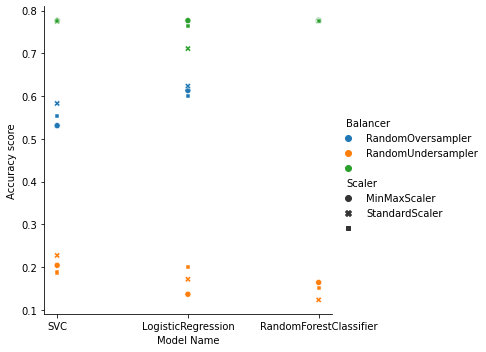

In [17]:
sns.relplot(data=df_classification, x="Model Name", y="Accuracy score", style="Scaler", hue="Balancer", kind="scatter")

In [19]:
write_pickle(path= os.path.join(base_path, classification_path, class_path, model_path, f"{model_path}_classification_df.pkl"), obj=df_classification)